## Process_poemhunter_data

**Description:**  Process and database the scraped poems from Poemhunter

The poems for this project were scraped from various sources.  One of these sources was "poemhunter.com", and the source code I used to scrape was largely borrowed from Chaim Gluck (https://github.com/chaimgluck.)  Here I clean the poems, separate them by sentence, and store various subsets in a database for use with my "PoeML" app.

In [3]:
import pandas as pd
import sqlalchemy # pandas-mysql interface library
import glob # for file manipulation
import sys # for defining behavior under errors
import numpy as np
import csv
import nltk
import re
import time
import re
import string
import spacy
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering, spectral_clustering
from sklearn.preprocessing import normalize
from collections import Counter, OrderedDict
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk import SnowballStemmer
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

### Load and view the data

In [2]:
# path and file names for both full poetry set and also cleaned set
datapath = "/Users/ctoews/Documents/Insight/Project/data/poems/"
filename = "full_df.csv"

In [5]:
#  store the poetry as a datafame
poetry = pd.read_csv(datapath+filename)
poetry.head()

,name,full_poem,number,birth,death
0,Deborah Ager,"When I knew, it was raining. Winter in decline...",10,1971,2016
1,Deborah Ager,"The yard half a yard, half a lake blue as a c...",10,1971,2016
2,Deborah Ager,They tell me that your heart has been found in...,10,1971,2016
3,Deborah Ager,The city is closing for the night. Stores draw...,10,1971,2016
4,Deborah Ager,Rain drenches the patio stones. All night was ...,10,1971,2016


Some of these poems are rather long.  We'll focus on shorter poems, so no single poem unbalances the dataset.

In [27]:
# calculate length for each poem, and plot it in a histogram
poetry['lengths'] = poetry['full_poem'].map(lambda x: len(x))

34330

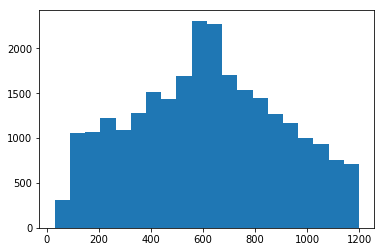

In [29]:
max_length = 1200
plt.hist(poetry.lengths.loc[poetry.lengths<max_length],20)
len(poetry.lengths.loc[poetry.lengths<max_length])
len(poetry)

In [31]:
# we'll store the short poems in "df"
df = poetry.loc[poetry.lengths<max_length,:]

In [7]:
engine = pml.connect_db()

*Display existing tables*

In [8]:
tables = engine.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
print(tables.fetchall())

[('sonnet_vector',), ('sonnet_full',), ('sonnet_lines',), ('sonnet_sentences',), ('poem_embeddings',)]


*Extract both full sonnets, sonnet sentences, and sonnet lines.*

In [9]:
query = "select * from sonnet_full;"
sonnet_full = pd.read_sql(query,engine)
sonnet_full.head()

,index,title,poem
0,0,I,"From fairest creatures we desire increase, Tha..."
1,1,II,"When forty winters shall besiege thy brow, And..."
2,2,III,Look in thy glass and tell the face thou viewe...
3,3,IV,"Unthrifty loveliness, why dost thou spend Upon..."
4,4,V,"Those hours, that with gentle work did frame T..."


In [11]:
query = "select * from sonnet_lines;"
sonnet_lines = pd.read_sql(query,engine)
sonnet_lines.head()

,index,title,line
0,0,I,"From fairest creatures we desire increase,"
1,1,I,"That thereby beauty's rose might never die,"
2,2,I,"But as the riper should by time decease,"
3,3,I,His tender heir might bear his memory:
4,4,I,"But thou, contracted to thine own bright eyes,"


In [12]:
query = "select * from sonnet_sentences order by index;"
sonnet_sentences = pd.read_sql(query,engine)
len(sonnet_sentences)
sonnet_sentences.head()

,index,title,sentence
0,0,I,"From fairest creatures we desire increase, Tha..."
1,1,I,"But thou, contracted to thine own bright eyes..."
2,2,I,"Thou that art now the world's fresh ornament,..."
3,3,I,"Pity the world, or else this glutton be, To e..."
4,4,II,"When forty winters shall besiege thy brow, And..."


In [978]:
#query = "drop table sonnet_sentences;"
#engine.execute(query)
#sonnet_sentences.to_sql('sonnet_sentences',engine)
#del sonnet_sentences['index']

## Clean, tokenize, and transform the text



In [13]:
# borrow parser from spacy
parser = spacy.load('en')
data = sonnet_sentences['sentence']

In [14]:
# load up shakespeare's stopwords
shakespeares_stopwords = []
f = open("../data/Shakespeare/shakespeares_stopwords.txt","r")
for line in f:
    if len(line)>1:
        shakespeares_stopwords.append(line.strip('\n'))

In [15]:
# A custom stoplist
STOPLIST = set(stopwords.words('english') + list(shakespeares_stopwords))
# List of symbols we don't care about
SYMBOLS = " ".join(string.punctuation).split(" ") + \
          ["-----", "---", "...", "“", "”", "'s"]

In [16]:
# Every step in a pipeline needs to be a "transformer". 
# Define a custom transformer to clean text using spaCy
class CleanTextTransformer(TransformerMixin):
    """
    Convert text to cleaned text
    """

    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

In [26]:
# A custom function to clean the text before sending it into the vectorizer
def cleanText(text):
    
    # import a dictionary of English contractions from another file
    from contractions import contractions_dict
    
    # replace the contractions with their expanded form
    for contraction, expansion in contractions_dict.items():
        text = text.replace(contraction.lower(),expansion.lower())
    
    # get rid of newlines
    text = text.strip().replace("\n", " ").replace("\r", " ").replace("-"," ").replace("\'st"," ")
    
    # lowercase
    text = text.lower()

    return text

In [27]:
# A custom function to tokenize the text using spaCy
# and convert to lemmas
def tokenizeText(sample):

    # get the tokens using spaCy
    tokens = parser(sample)

    # lemmatize
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() 
                      if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas

    # stoplist the tokens
    tokens = [tok for tok in tokens if tok not in STOPLIST]

    # stoplist symbols
    tokens = [tok for tok in tokens if tok not in SYMBOLS]

    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")
    
    
    return tokens

## Cluser using NMF

In [52]:
# define the number features, topics, and how many 
# words/documents to display later on
n_features      = 1000
n_topics        = 5
n_top_words     = 5
n_top_documents = 5

# Use tf-idf vectorizer
vectorizer = TfidfVectorizer(max_features=n_features,
                             tokenizer=tokenizeText,
                             stop_words='english')
#vectorizer = CountVectorizer(max_features=n_features,
#                             tokenizer=tokenizeText,
#                             stop_words='english')

        
# use NMF model with the Frobenius norm
nmf = NMF(n_components=n_topics, random_state=1, 
          solver='mu', beta_loss='frobenius')

# use NMF model with the Frobenius norm
#nmf = NMF(n_components=n_topics, random_state=1)

# put it all in a pipeline
pipe = Pipeline([('cleanText', CleanTextTransformer()), 
                 ('vectorizer', vectorizer), ('nmf', nmf)])

In [53]:
# grab term-document matrix
transform = pipe.fit_transform(data)

In [54]:
def display_topics(vectorizer, nmf, W, df, n_top_words, n_top_documents):
    ''' Print out topics discovered by a model '''
    
    feature_names = vectorizer.get_feature_names()
    
    for topic_id, topic in enumerate(nmf.components_):
        print('Topic #%02d: %s ' % (topic_id+1, ' '.join([str(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]])))
        
        top_doc_indices = np.argsort( W[:,topic_id] )[::-1][0:n_top_documents]
        avg_polarity = 0
        for doc_index in top_doc_indices:
            doc = TextBlob(data.iloc[doc_index])
            avg_polarity += doc.sentiment[0]
            print('Line: {} (with polarity {}) \n'.format(data.iloc[doc_index], 
                                     doc.sentiment[0]))
            #print(df['reviewText'].iloc[doc_index]+"\n")
        print("Average polarity: %4.2f" % (avg_polarity / n_top_documents))
        print()

display_topics(vectorizer, nmf, transform, data, n_top_words, n_top_documents)

Topic #01: love know true hate make 
Line:  No love, my love, that thou mayst true love call; All mine was thine, before thou hadst this more (with polarity 0.32) 

Line:  Make but my name thy love, and love that still, And then thou lov'st me for my name is 'Will (with polarity 0.5) 

Line: Take all my loves, my love, yea take them all; What hast thou then more than thou hadst before (with polarity 0.5) 

Line:  If it be not, then love doth well denote Love's eye is not so true as all men's (with polarity 0.45) 

Line:  O! love's best habit is in seeming trust, And age in love, loves not to have years told (with polarity 0.6666666666666666) 

Average polarity: 0.49

Topic #02: beauty fair sweet make old 
Line: -- Hers by thy beauty tempting her to thee, Thine by thy beauty being false to me (with polarity -0.4000000000000001) 

Line: When in the chronicle of wasted time I see descriptions of the fairest wights, And beauty making beautiful old rime, In praise of ladies dead and lovely 

## Visualization of topic clusters

In [31]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
output_notebook()

Loading BokehJS ...

In [32]:
data_vectorized = vectorizer.fit_transform(data)

In [33]:
svd = TruncatedSVD(n_components=2)
svd = TruncatedSVD(n_components=2)
documents_2d = svd.fit_transform(data_vectorized)
 
df = pd.DataFrame(columns=['x', 'y', 'document'])
df['x'], df['y'], df['document'] = documents_2d[:,0], documents_2d[:,1], range(len(data))
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="document", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

In [56]:
len(df)

1000

In [68]:
svd = TruncatedSVD(n_components=2)
words_2d = svd.fit_transform(data_vectorized.T)
 
df = pd.DataFrame(columns=['x', 'y', 'word'])
df['x'], df['y'], df['word'] = words_2d[:,0], words_2d[:,1], vectorizer.get_feature_names()
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="word", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

## Example of how to process untrained text

In [35]:
from sklearn.metrics.pairwise import euclidean_distances
 
def most_similar(x, Z, top_n=5):
    dists = euclidean_distances(x.reshape(1, -1), Z)
    pairs = enumerate(dists[0])
    most_similar = sorted(pairs, key=lambda item: item[1])[:top_n]
    return most_similar
 

In [38]:
text = "flower heart joy peace"
x = nmf.transform(vectorizer.transform([text]))[0]

similarities = most_similar(x, transform)
document_id, similarity = similarities[0]

print("original text:\n\n", x)
print("closest poem:\n\n", data[document_id][:1000])

original text:

 [  7.93308172e-03   5.38165756e-04   2.25310040e-14   5.60258079e-03
   3.72973013e-80   2.62144364e-24   0.00000000e+00   3.94482887e-03
   8.86628478e-03   3.15688754e-02]
closest poem:

  Since saucy jacks so happy are in this, Give them thy fingers, me thy lips to kiss


Text(0,0.5,'True')

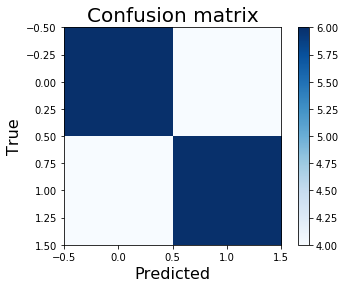

In [67]:
cm = np.array([[6,4],[4,6]])
plt.imshow(cm,cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion matrix',fontsize=20)
plt.xlabel('Predicted',fontsize=16)
plt.ylabel('True',fontsize=16)

In [ ]:
cm = confusion_matrix(y_test_counts, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['US','UK'], normalize=True, title='Confusion matrix')
plt.show()
print(cm)

## Implement spaCY word-dictionary

This section deviates from the one above in that instead of performing NMF, it simply embeds each poem in spaCY's pre-trained dictionary, and does the same with the semantic labels emerging from the pictures.

In [39]:
data = sonnet_sentences['sentence']

In [40]:
# strip blanks and other terrible things
data_clean = []
for poem in data:
    data_clean.append(cleanText(poem))

In [41]:
# tokenize
poem_token = []
for poem in data_clean:
    poem_token.append(tokenizeText(poem))

In [42]:
# recombine
input_poems = []
for token in poem_token:
    input_poems.append(' '.join(token))

In [43]:
#parse
parsed_poems = []
for poem in input_poems:
    parsed_poems.append(parser(poem))

In [45]:
# put all vectors into a big numpy array
allvectors = np.zeros((len(parsed_poems),384))
i = 0
bad_idx = []
for pp in parsed_poems:
    if len(pp)==0:
        bad_idx.append(i)
    else:
        allvectors[i,:] = pp.vector
    i+=1

In [993]:
poem_embeddings = pd.DataFrame(allvectors)
norm_poem_embeddings = normalize(poem_embeddings,axis=1)

## Store embeddings in pickle files

In [742]:
poem_embeddings.to_pickle('allvecs.pkl')

with open('sharespeares_stopwords.pkl','wb') as file:
    pickle.dump(shakespeares_stopwords,file)